# EIGSEP Image Fit

Aaron Parsons

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.image import imread
import torch
from eigsep_terrain.marjum_dem import MarjumDEM as DEM
from eigsep_terrain.img import PRM_ORDER, PRM_ORDER_FULL, HorizonImage, PositionSolver, LogLikeOp
import healpy
import pymc as pm
import pytensor
pytensor.config.cxx = ""    #type: ignore
import pytensor.tensor as pt
from pytensor.compile.ops import as_op
import os, sys, glob, tqdm
import multiprocessing as mp
import arviz
from scipy.optimize import minimize
import emcee
import corner
import time

%matplotlib widget

# cache file setup

In [ ]:
CACHE_FILE = 'marjum_dem.npz'
dem = DEM(cache_file=CACHE_FILE)

In [ ]:
dem['platform'] = np.array([1648, 2024, 1796])

meta = {}
meta['0817'] = {
    'best_prms': ( 1732.31,  2069.73,   1760.89,  1.4682,  3.6963, -0.0521,  9849.36),  #[LOSS= 0.0378]
    'ant_px': (2*1366, 2*1221),
}
meta['0833'] = {
    'best_prms': ( 1611.38,  1847.62,   1659.85,  1.2062,  1.2401, -0.0250,  5072.38),  #[LOSS= 0.0254]
    'ant_px': (1606, 2700),
}

#meta['0834'] = {
#    'best_prms': ( 1642.45,  1887.80,   1678.94,  1.1787,  1.2417, -0.0310,  2933.66),  #[LOSS= 0.0685]
#    'ant_px': (1622, 2251),
#}

meta['0860'] = {
    #'best_prms': ( 1539.90,  1989.78,   1765.54,  1.5423,  0.6162,  0.1541,  2328.29),  #[LOSS= 0.0206]
    #'best_prms': ( 1538.80,  2001.28,   1765.46,  1.5411,  0.6109,  0.1589,  2328.29),  #[LOSS= 0.0166]
    'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5421,  0.6131,  0.1584,  2328.30),  #[LOSS= 0.0151]
    'ant_px': (2924, 1945),
}

for k in meta.keys():
    dem[k] = np.asarray(meta[k]['best_prms'][:3], dtype=np.float32)
    
files = sorted(glob.glob('//Users/komalkaur/Desktop/eigsep_stuff/hrzn_mapping/imgs/*.jpg'))
#files = sorted(glob.glob('/home/aparsons/Downloads/IMG_08*.jpg'))[-1:]
print(files)
imgs = [HorizonImage(f, meta) for f in files]
imgs = [img for img in imgs if img.key in meta]


In [ ]:
dem.interp_alt(imgs[-1].prms['e'], imgs[-1].prms['n'])


In [ ]:
def plot_img(ax, data, res=dem.res, xlabel=True, ylabel=True,
             colorbar=False, cmap='terrain', erng=None, nrng=None, **kw):
    '''Plot maps with standard format.'''
    if nrng is None:
        nrng = (0, data.shape[0] * res)
    if erng is None:
        erng = (0, data.shape[1] * res)
    extent = erng + nrng
    im = ax.imshow(data, extent=extent, cmap=cmap, origin='lower', interpolation='nearest', **kw)
    if colorbar:
        plt.colorbar(im)
    if xlabel:
        ax.set_xlabel('East [m]')
    if ylabel:
        ax.set_ylabel('North [m]')

# ray tracing

In [ ]:
# overlay ray tracing

if False:
    fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(7, 4 * 3))
    r_imgs = {}
    sl = slice(None, None, 4)
    img_pkg = imgs[-1]
    axes[0].imshow(img_pkg.img[sl,sl], origin='lower')
    axes[2].imshow(img_pkg.img[sl,sl], origin='lower')
    r_imgs[img_pkg.key] = img_pkg.ray_distance(dem, img_pkg.get_rays()[...,sl,sl])
    axes[1].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar')
    axes[0].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar', alpha=0.4)
    plt.tight_layout()


In [ ]:
# i = imgs[0]
# npz = np.load(i.npzfile)
# plt.figure()
# plt.imshow(npz['sky'])


In [ ]:
if False:
    fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
    if len(imgs) == 1:
        axes = [axes]
    r_imgs = {}
    sl = slice(None, None, 8)
    for cnt, img_pkg in enumerate(imgs):
        axes[cnt].imshow(img_pkg.img[sl,sl], origin='lower')
        r_imgs[img_pkg.key] = img_pkg.ray_distance(dem, img_pkg.get_rays()[...,sl,sl])
        axes[cnt].imshow(r_imgs[img_pkg.key], origin='lower', cmap='gist_ncar', alpha=0.4)
    plt.tight_layout()
    

In [ ]:
if False:
    fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
    if len(imgs) == 1:
        axes = [axes]
    for cnt, img_pkg in enumerate(imgs):
        axes[cnt].imshow(img_pkg.img, origin='lower')
        axes[cnt].imshow(img_pkg.sky_mask, origin='lower', alpha=0.3)
        axes[cnt].imshow(img_pkg.horizon_mask, origin='lower', alpha=0.3)
        mask = img_pkg.mask_near_horizon(50)
        x, y = img_pkg.choose_pixels(mask=mask, N=16000//3)
        is_sky = img_pkg.sky_mask[x, y]
        axes[cnt].plot(y[is_sky], x[is_sky], 'b,')
        axes[cnt].plot(y[~is_sky], x[~is_sky], 'r,')
        axes[cnt].plot(*img_pkg.meta['ant_px'], 'k+')


In [ ]:
#nside = 512
##e0, n0, u0 = (1754, 2100, 1747)
#e0, n0, u0 = start_point = np.array((1767, 2095, 1759), dtype=float)
#rays = et.ray.healpix_rays(nside)
##e0, n0, u0 = start_point = np.array(dem['1P'], dtype=float)
##e0, n0, u0 = (0, 0, 1759)

In [ ]:
#healpy.mollview(h.map)
#healpy.mollview(np.log10(ray_trace(start_point)), cmap='plasma')
#healpy.mollview(np.log10(r), cmap='plasma')
#healpy.mollview(np.log10(r2), cmap='plasma')
#healpy.mollview(T[-1], cmap='plasma')
#healpy.mollview((T_sky_full[:, 180]), cmap='plasma')

In [ ]:
# for one image

if False:
    I = imgs[2]
    I.reset_pixel_choice()
    I.horizon_ray_loss(dem, cnt=16000);
    ant_ray = I.get_rays(np.array(I.meta['ant_px'][::-1]))
    prms = dict(zip(PRM_ORDER, I.get_prms()))
    r_ant = dem['platform'] - np.array([prms['e'], prms['n'], prms['u']])

    delta_theta = np.arccos(np.dot(ant_ray, r_ant) / (np.linalg.norm(ant_ray) * np.linalg.norm(r_ant))) # rad
    BOX_SIZE = 0.3 # m
    sigma_theta = BOX_SIZE / np.linalg.norm(r_ant)

    logL = -delta_theta / (2 * sigma_theta**2) # :0
    logL
                        

# 3 param mcmc
## setup

In [ ]:
# setup for mcmc fitting only antenna ENU
sigmas = (30.0, 30.0, 30.0, np.deg2rad(5.0), np.deg2rad(5.0), np.deg2rad(5.0), 0.1)
BOX_SIZE = 0.3 # m
ANT_POS_ERR = 20 #m
ant_pos_prior = np.array([1646, 2022, 1782])
fit_imgs = []
static_imgs = imgs
n_rays = 1600

pos_slvr = PositionSolver(ant_pos_prior, fit_imgs, static_imgs, n_rays, dem, ant_pos_err=20, box_size=0.3)


## pymc

In [ ]:
# old: pymc
# def build_model():
#     """
#     eps: per-pixel error rate for mismatches (small)
#     """

#     with pm.Model() as model:
#         pos_slvr.set_mcmc_sigmas()
#         prms = pos_slvr.get_mcmc_prms()
               
#         theta = pt.stack(prms)
#         logp = pos_slvr.total_loss(theta)
            
#         pm.Potential("lik", logp)

#     return model

# if True:
#     with build_model() as model:
#         # step = pm.DEMetropolisZ(
#         step = pm.Metropolis(
#             S=np.array(pos_slvr.sigmas),
#             scaling=.01,      # much bigger than 1e-3, may need to tune this
#             tune='scaling',   # let it adapt scale
#             tune_interval=50, # adapt more often than default 100
#         )
        
#         trace = pm.sample(
#             draws=5000,
#             tune=3000,
#             chains=4,   # go back to 4 once this works
#             step=step,
#             cores=4,
#             random_seed=42,
#             progressbar=True,
#         )
#     arviz.to_netcdf(trace, f"{I.key}_trace.nc");
#     print(f"Accepted step fraction = {float(trace.sample_stats.accepted.mean()): 4.3f}")
#     # rejecting most steps = steps too big
#     # accepting most steps = steps too small

In [ ]:
# trace_files = sorted(glob.glob("*.nc"))
# print(trace_files)
# traces = {f.split('_')[0]: arviz.from_netcdf(f) for f in trace_files}


In [ ]:
# # Load the trace file
# trace = arviz.from_netcdf("0860_trace.nc")

# # Check if it actually has samples (not constants)
# print("Checking if samples vary:")
# for var in trace.posterior.data_vars:
#     data = trace.posterior[var].values
#     print(f"{var}: shape={data.shape}, std={data.std():.6e}, range={data.max()-data.min():.6e}")

In [ ]:
# # Check if 0860 parameters actually vary
# posterior = traces['0860'].posterior

# for var in posterior.data_vars:
#     data = posterior[var].values.flatten()
#     print(f"{var}: min={data.min():.4f}, max={data.max():.4f}, "
#           f"unique={len(np.unique(data))}, std={data.std():.6f}")

In [ ]:
# traces

In [ ]:
# fig = plt.figure(figsize=(8, 8))
# # type(traces['0860'])
# corner.corner(traces['0860'], fig=fig);

In [ ]:
# #e,n,u = dem.latlon_to_enu(39.247907, -113.402715)
# #u = dem.interp_alt(e, n)
# #print(e, n, u)
# fig, ax = plt.subplots()
# e0, n0, u0 = dem['platform']
# rng = 750
# plot_img(ax, dem.data, dem.res)
# plt.plot([e0], [n0], 's', color='k')
# for img in imgs[-1:]:
#     e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
#     plt.plot([e], [n], '+', color='blue')
#     ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
#     plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
#     trace = traces[img.key]
#     # try:
#     #     plt.plot(np.asarray(trace.posterior[f'{img.key}_e']).flatten(), np.asarray(trace.posterior[f'{img.key}_n']).flatten(), '.');
#     # except(KeyError):
#     plt.plot(np.asarray(trace.posterior['e']).flatten(), np.asarray(trace.posterior['n']).flatten(), '.');


In [ ]:
# summary = arviz.summary(posterior)
# summary


In [ ]:
# avgs = summary['mean']
# mean_ant_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
# mean_ant_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
# mean_ant_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

# print(f'antenna enu from mcmc: e: {np.round(mean_ant_e)}, n:{np.round(mean_ant_n)}, u:{np.round(mean_ant_u)}')


In [ ]:
# avgs = summary['r_hat']
# mean_r_hat_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
# mean_r_hat_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
# mean_r_hat_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

# print(f'antenna r_hat from mcmc: e: {mean_r_hat_e}, n:{mean_r_hat_n}, u:{mean_r_hat_u}')


In [ ]:
# avgs = summary['ess_bulk']
# mean_ess_bulk_e = np.mean([avgs['ant_e[0]'], avgs['ant_e[1]'], avgs['ant_e[2]']])
# mean_ess_bulk_n = np.mean([avgs['ant_n[0]'], avgs['ant_n[1]'], avgs['ant_n[2]']])
# mean_ess_bulk_u = np.mean([avgs['ant_u[0]'], avgs['ant_u[1]'], avgs['ant_u[2]']])

# print(f'antenna ess_bulk from mcmc: e: {mean_ess_bulk_e}, n:{mean_ess_bulk_n}, u:{mean_ess_bulk_u}')


In [ ]:
# arviz.plot_trace(posterior)


In [ ]:
# arviz.plot_autocorr(posterior)


In [ ]:
# # Test with prior
# theta_prior = ant_pos_prior
# pos_slvr.set_mcmc_prms(theta_prior)
# logp_prior = pos_slvr.total_loss(theta_prior)
# print(f"Log prob at prior [1646, 2022, 1782]: {logp_prior}")

# # Test with MCMC result
# theta_mcmc = np.array([mean_ant_e, mean_ant_n, mean_ant_u])
# pos_slvr.set_mcmc_prms(theta_mcmc)
# logp_mcmc = pos_slvr.total_loss(theta_mcmc)
# print(f"Log prob at MCMC [1804, 1804, 1804]: {logp_mcmc}")

# print(f"\nMCMC result is better: {logp_mcmc > logp_prior}")
# print(f"Difference: {logp_mcmc - logp_prior}")

In [ ]:
# # Test a few random points
# import random
# for _ in range(5):
#     test_pos = ant_pos_prior + np.random.randn(3) * 50  # Random points near prior
#     pos_slvr.set_mcmc_prms(test_pos)
#     logp_test = pos_slvr.total_loss(test_pos)
#     print(f"Position {test_pos}: logp = {logp_test}")

## MAP

In [ ]:
# MAP
def neg_log_prob(theta):
    return -pos_slvr.total_loss(theta, ray_cnt=1600)

result = minimize(
    neg_log_prob,
    x0=ant_pos_prior,
    method='Nelder-Mead',  # or 'Powell', doesn't need gradients
    options={'disp': True, 'maxiter': 1000}
)

print(f"Optimized position (MAP result): {result.x}")
print(f"Log probability: {-result.fun}")

In [ ]:
# 1. The best estimate (MAP from scipy)
map_estimate = result.x
print(f"MAP Estimate:")
print(f"  ant_e: {map_estimate[0]:.2f}")
print(f"  ant_n: {map_estimate[1]:.2f}")
print(f"  ant_u: {map_estimate[2]:.2f}")


In [ ]:
# print(f"Optimization success: {result.success}")
# print(f"Optimization message: {result.message}")
# print(f"Number of iterations: {result.nit}")
# print(f"Number of function evaluations: {result.nfev}")

## testing convergence

In [ ]:
# # Try with more iterations and tighter tolerance
# # Or use L-BFGS-B with bounds
# result = minimize(
#     neg_log_prob,
#     x0=ant_pos_prior,
#     method='L-BFGS-B',
#     options={'disp': True, 'maxiter': 10000, 'ftol': 1e-10}
# )

# print(f"\nOptimization converged: {result.success}")
# print(f"Final gradient norm: {np.linalg.norm(approx_fprime(result.x, neg_log_prob, 1e-6))}")
# print(f"Optimized position: {result.x}")
# print(f"Log probability: {-result.fun}")

# # Now try Hessian again
# if result.success:
#     hessian = compute_hessian(neg_log_prob, result.x, eps=1e-5)
    
#     try:
#         post_cov = np.linalg.inv(hessian)
#         post_std = np.sqrt(np.diag(post_cov))
        
#         print(f"\nProper 95% CI:")
#         print(f"  ant_e: {result.x[0]:.2f} ± {1.96*post_std[0]:.2f}")
#         print(f"  ant_n: {result.x[1]:.2f} ± {1.96*post_std[1]:.2f}")
#         print(f"  ant_u: {result.x[2]:.2f} ± {1.96*post_std[2]:.2f}")
#     except:
#         print("Hessian still singular")

problem is unconstrained: issue with ant_loss?
update: fixed ant_loss

## emcee

In [ ]:
# # emcee: fitting only antenna ENU

# def log_probability(theta):
#     """theta = [ant_e, ant_n, ant_u]"""
#     # Prior
#     log_prior = -0.5 * np.sum(((theta - ant_pos_prior) / 30.0)**2)
    
#     # Likelihood
#     log_like = pos_slvr.total_loss(theta) - log_prior  # total_loss includes prior, so subtract it
    
#     return log_prior + log_like

# # Initialize walkers near MAP
# ndim = 3
# nwalkers = 32
# pos = result.x + 1e-2 * np.random.randn(nwalkers, ndim)

# # Run MCMC
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
# sampler.run_mcmc(pos, 5000, progress=True)

# # Get samples
# samples = sampler.get_chain(discard=1000, thin=15, flat=True)
# # plt.savefig('corner_emcee.png')


In [ ]:
# np.savez('samples.npz', samples=samples)

# # Corner plot!
# fig = corner.corner(samples, labels=['ant_e', 'ant_n', 'ant_u'], truths=result.x)


In [ ]:
# # 1. Posterior mean (Bayes-optimal under squared loss)
# posterior_mean = np.mean(samples, axis=0)
# print("Posterior Mean:")
# print(f"  E: {posterior_mean[0]:.2f} m")
# print(f"  N: {posterior_mean[1]:.2f} m")
# print(f"  U: {posterior_mean[2]:.2f} m")

# # 2. Posterior median (robust to outliers)
# posterior_median = np.median(samples, axis=0)
# print("\nPosterior Median:")
# print(f"  E: {posterior_median[0]:.2f} m")
# print(f"  N: {posterior_median[1]:.2f} m")
# print(f"  U: {posterior_median[2]:.2f} m")

# # 3. MAP estimate (what you got from scipy)
# print("\nMAP (from optimization):")
# print(f"  E: {result.x[0]:.2f} m")
# print(f"  N: {result.x[1]:.2f} m")
# print(f"  U: {result.x[2]:.2f} m")

# # 4. Uncertainties (standard deviation)
# posterior_std = np.std(samples, axis=0)
# print("\nPosterior Standard Deviation:")
# print(f"  E: ±{posterior_std[0]:.2f} m")
# print(f"  N: ±{posterior_std[1]:.2f} m")
# print(f"  U: ±{posterior_std[2]:.2f} m")

# # 5. Credible intervals (95%)
# ci_lower = np.percentile(samples, 2.5, axis=0)
# ci_upper = np.percentile(samples, 97.5, axis=0)

# print("\n95% Credible Intervals:")
# for i, label in enumerate(['E', 'N', 'U']):
#     print(f"  {label}: [{ci_lower[i]:.2f}, {ci_upper[i]:.2f}] m")

# # 6. Final answer with uncertainty
# print("\n" + "="*50)
# print("FINAL RESULT:")
# print("="*50)
# final_position = posterior_mean  # or posterior_median, both are reasonable
# print(f"Antenna Position:")
# print(f"  East:  {final_position[0]:.2f} ± {posterior_std[0]:.2f} m")
# print(f"  North: {final_position[1]:.2f} ± {posterior_std[1]:.2f} m")
# print(f"  Up:    {final_position[2]:.2f} ± {posterior_std[2]:.2f} m")
# print(f"\n95% Credible Region:")
# print(f"  E: [{ci_lower[0]:.2f}, {ci_upper[0]:.2f}] m")
# print(f"  N: [{ci_lower[1]:.2f}, {ci_upper[1]:.2f}] m")
# print(f"  U: [{ci_lower[2]:.2f}, {ci_upper[2]:.2f}] m")


## testing emcee convergence

In [ ]:
# # 1. TRACE PLOTS - Visual check for convergence
# samples_full = sampler.get_chain()
# fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
# labels = ['ant_e', 'ant_n', 'ant_u']

# for i in range(3):
#     ax = axes[i]
#     ax.plot(samples_full[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples_full))
#     ax.set_ylabel(labels[i])
#     ax.axhline(posterior_mean[i], color="r", linestyle="--", label="Mean")
    
# axes[-1].set_xlabel("Step number")
# axes[0].legend()
# plt.tight_layout()
# plt.savefig('trace_plots.png')
# plt.show()

# # 2. ACCEPTANCE FRACTION
# print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
# print("✓ Good if between 0.2-0.5")

# # 3. AUTOCORRELATION TIME
# try:
#     tau = sampler.get_autocorr_time()
#     print(f"\nAutocorrelation time: {tau}")
#     n_effective = nwalkers * 5000 / np.max(tau)
#     print(f"Effective sample size: {n_effective:.0f}")
#     print(f"✓ Good if > 1000")
# except:
#     print("⚠ Could not compute autocorrelation - chain might be too short")

# # 4. LOG PROBABILITY CHECK - Most important!
# # Calculate log prob for random samples from posterior
# n_check = 100
# random_indices = np.random.choice(len(samples), n_check, replace=False)

# log_probs = []
# for idx in random_indices:
#     theta = samples[idx]
#     logp = pos_slvr.total_loss(theta)
#     log_probs.append(logp)

# log_probs = np.array(log_probs)

# print(f"\n=== LOG PROBABILITY CHECK ===")
# print(f"Prior log prob: {pos_slvr.total_loss(ant_pos_prior):.1f}")
# print(f"MAP log prob: {pos_slvr.total_loss(result.x):.1f}")
# print(f"Posterior samples log prob:")
# print(f"  Mean: {np.mean(log_probs):.1f}")
# print(f"  Median: {np.median(log_probs):.1f}")
# print(f"  Min: {np.min(log_probs):.1f}")
# print(f"  Max: {np.max(log_probs):.1f}")

# # THIS IS THE KEY CHECK:
# print(f"\n✓ Samples should have log prob similar to MAP")
# print(f"  Difference: {np.mean(log_probs) - pos_slvr.total_loss(result.x):.1f}")
# print(f"  (Should be within ~10-50 of each other)")

# # 5. Compare posterior mean to MAP
# print(f"\n=== POSTERIOR vs MAP ===")
# print(f"Distance: {np.linalg.norm(posterior_mean - result.x):.3f} m")
# print(f"✓ Should be small (< few meters)")

# # 6. Verify samples are in reasonable range
# print(f"\n=== SAMPLE RANGES ===")
# for i, label in enumerate(['E', 'N', 'U']):
#     print(f"{label}: [{samples[:, i].min():.1f}, {samples[:, i].max():.1f}]")
#     print(f"  Prior: {ant_pos_prior[i]:.1f}, MAP: {result.x[i]:.1f}")

# # If this is approximately True, you're golden:
# logp_samples_mean = np.mean(log_probs)
# logp_map = pos_slvr.total_loss(result.x)

# print(f"\nSANITY CHECK:")
# print(f"Samples have similar log prob to MAP? {abs(logp_samples_mean - logp_map) < 100}")

## 3 param emcee plot

In [ ]:
# #e,n,u = dem.latlon_to_enu(39.247907, -113.402715)
# #u = dem.interp_alt(e, n)
# #print(e, n, u)
# fig, ax = plt.subplots()
# e0, n0, u0 = dem['platform']
# rng = 750
# plot_img(ax, dem.data, dem.res)
# mean_ant_e = posterior_mean[0]
# mean_ant_n = posterior_mean[1]
# mean_ant_u = posterior_mean[2]
# plt.plot([e0], [n0], 's', color='k')
# for img in imgs[-1:]:
#     e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
#     plt.plot([e], [n], '+', color='blue')
#     ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
#     plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
#     plt.plot(mean_ant_e, mean_ant_n, '.');

## 3 param emcee loss


In [ ]:
# theta = np.array([mean_ant_e, mean_ant_n, mean_ant_u])
# # theta = ant_pos_prior
# pos_slvr.set_mcmc_prms(theta)
# logp = pos_slvr.total_loss(theta)
# logp


In [ ]:
# # ant_loss on each image
# for i in imgs:
#     ant_pos = np.array([mean_ant_e, mean_ant_n, mean_ant_u])
#     L = i.ant_loss(ant_pos, 0.3)
#     print(f'image {i} ant_loss: {L}')


In [ ]:
# # plot antenna fit with images
# if True:
#     fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
#     if len(imgs) == 1:
#         axes = [axes]
#     for cnt, img_pkg in enumerate(imgs):
#         ant_ray = img_pkg.get_rays(np.array(img_pkg.meta['ant_px'][::-1]))
#         r_ant = ant_pos - np.array([img_pkg.prms['e'], img_pkg.prms['n'], img_pkg.prms['u']])
#         delta_theta = np.arccos(np.dot(ant_ray, r_ant) / (np.linalg.norm(ant_ray) * np.linalg.norm(r_ant)))
#         print(f'delta theta for img {cnt}: {np.rad2deg(delta_theta)} degrees')
#         print(f'r_ant for img {cnt}: {np.linalg.norm(r_ant)}')

#         # axes[cnt].imshow(img_pkg.img, origin='lower')
#         # axes[cnt].imshow(img_pkg.sky_mask, origin='lower', alpha=0.3)
#         # axes[cnt].imshow(img_pkg.horizon_mask, origin='lower', alpha=0.3)
#         # mask = img_pkg.mask_near_horizon(50)
#         # x, y = img_pkg.choose_pixels(mask=mask, N=16000//3)
#         # is_sky = img_pkg.sky_mask[x, y]
#         # axes[cnt].plot(y[is_sky], x[is_sky], 'b,')
#         # axes[cnt].plot(y[~is_sky], x[~is_sky], 'r,')
#         # axes[cnt].plot(*img_pkg.meta['ant_px'], 'k+')


In [ ]:
# L = 0.0
# eps = 0.01
# for cnt, img in enumerate(imgs):
#     L += img.horizon_ray_loss(dem, cnt=n_rays)
# L = np.array(L / (len(imgs) + eps), dtype=np.float32)
# logp = len(imgs) * n_rays * (1 - L) * np.log(1.0 - eps) + len(imgs) * n_rays * L * np.log(eps)
# for cnt, img in enumerate(imgs):
#     logL = img.ant_loss(ant_pos, BOX_SIZE)
#     logp += logL
# print(f'logp with hrzn ray loss: {logp}')


# 24 param mcmc

mcmc with all imgs in fit_imgs

In [ ]:
# mcmc with all images and priors
# not vectorized nor resumable
# if False:
#     def log_probability(theta):
#         log_prior = -0.5 * np.sum(((theta - ant_pos_prior_24) / 30.0)**2)
#         log_like = pos_slvr2.total_loss(theta) - log_prior
#         return_prob = log_prior + log_like
#         if np.isnan(return_prob) or np.isinf(return_prob):
#             return -np.inf
#         else:
#             return return_prob

#     ndim = 24
#     nwalkers = 48  

#     pos = ant_pos_prior_24 + 1e-2 * np.random.randn(nwalkers, ndim)

#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
#     sampler.run_mcmc(pos, 5000, progress=True)
#     samples = sampler.get_chain(discard=1000, thin=15, flat=True)


In [ ]:
# vectorized and resumable
fit_imgs = imgs
static_imgs = []
pos_slvr2 = PositionSolver(ant_pos_prior, fit_imgs, static_imgs, n_rays, dem, ant_pos_err=20, box_size=0.3)
ant_pos_prior_24 = np.hstack((imgs[0].meta['best_prms'], imgs[1].meta['best_prms'], imgs[2].meta['best_prms'], result.x))

def log_probability(theta):
    """Single walker evaluation."""
    log_prior = -0.5 * np.sum(((theta - ant_pos_prior_24) / 30.0)**2)
    log_like = pos_slvr2.total_loss(theta) - log_prior
    return_prob = log_prior + log_like
    if np.isnan(return_prob) or np.isinf(return_prob):
        return -np.inf
    return return_prob

# Setup
ndim = 24
nwalkers = 48
total_steps = 5000
checkpoint_file = "mcmc_checkpoint.h5"

if False:
    if os.path.exists(checkpoint_file):
        backend = emcee.backends.HDFBackend(checkpoint_file)
        print(f"Resuming from step {backend.iteration}")
        if backend.iteration > 0:
            pos = backend.get_last_sample()
        else:
            pos = ant_pos_prior_24 + 1e-2 * np.random.randn(nwalkers, ndim)
    else:
        backend = emcee.backends.HDFBackend(checkpoint_file)
        backend.reset(nwalkers, ndim)
        pos = ant_pos_prior_24 + 1e-2 * np.random.randn(nwalkers, ndim)

    from schwimmbad import MultiPool

    with MultiPool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability,
            pool=pool, backend=backend
        )
        sampler.run_mcmc(pos, remaining_steps, progress=True)

    # Save results
    reader = emcee.backends.HDFBackend(checkpoint_file)
    samples_24 = reader.get_chain(discard=1000, thin=15, flat=True)



In [ ]:
if False:
    np.savez('samples24.npz', samples=samples_24)
    print(f"Done! Saved {samples_24.shape[0]} samples")


In [ ]:
# samples_24 = np.load('samples24.npz')['samples']
samples_24 = np.load('samples2.npz')['samples']
posterior_mean_24 = np.mean(samples_24, axis=0)


In [ ]:
# Corner plot!
# fig = corner.corner(samples_24, truths=result.x)


## 24 param mcmc plot

In [ ]:
# reassign image paramters to what the mcmc found, save original in a variable
initial_img_0_prms = imgs[0].prms
initial_img_1_prms = imgs[1].prms
initial_img_2_prms = imgs[2].prms

imgs[0].set_prms(posterior_mean_24[:7])
imgs[1].set_prms(posterior_mean_24[7:14])
imgs[2].set_prms(posterior_mean_24[14:21])


In [ ]:
# plot new image locations on top of original; rays drawn from new img positions
fig, ax = plt.subplots()
plot_img(ax, dem.data, dem.res)

plt.plot(initial_img_0_prms['e'], initial_img_0_prms['n'], '+', color='red')
plt.plot(initial_img_1_prms['e'], initial_img_1_prms['n'], '+', color='red')
plt.plot(initial_img_2_prms['e'], initial_img_2_prms['n'], '+', color='red')

for img in imgs:
    e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
    plt.plot([e], [n], '+', color='blue')
    ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
    plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
    plt.plot(posterior_mean_24[-3], posterior_mean_24[-2], '.', color='magenta')


## testing convergence

In [ ]:
# examine traces
fig, ax = plt.subplots()
ax.plot(samples_24[:, -2])

TODO: decrease number of rays near the horizon. examine traces for cyclic stuff.

In [ ]:
# save old masks
old_masks = np.array([img.horizon_mask for img in imgs])


In [ ]:
def mess_w_px_dist(px_dist):
    for img in imgs:
        img.horizon_mask = img.mask_near_horizon(px_dist)
    pos_slvr2.total_loss(posterior_mean_24, ray_cnt=n_rays) # default n_rays


In [ ]:
def mess_w_num_rays(num_rays):
    pos_slvr2.total_loss(posterior_mean_24, ray_cnt=num_rays)

In [ ]:
def time_mess_w_px_dist(px_dist):   
    start = time.perf_counter()
    mess_w_px_dist(px_dist)
    end = time.perf_counter()
    # print(f"Runtime for px_dist = {px_dist}: {end - start:.6f} seconds")
    return end - start
    

In [ ]:
def time_mess_w_num_rays(num_rays):   
    start = time.perf_counter()
    mess_w_num_rays(num_rays)
    end = time.perf_counter()
    # print(f"Runtime for num_rays = {num_rays}: {end - start:.6f} seconds")
    return end - start
    

In [ ]:
# testing runtime by changing num_rays
runtimes = []
for i in range(0, n_rays):
    runtimes.append(time_mess_w_num_rays(i))
fix, ax = plt.subplots()
ax.plot(runtimes)
ax.set_title('testing runtime by changing num_rays and default px_dist')
ax.set_ylabel('runtime')


In [ ]:
# testing runtime by changing px_dist
runtimes = []
for i in range(0, 150): # 0 to default px_dist
    runtimes.append(time_mess_w_px_dist(i))
fix, ax = plt.subplots()
ax.plot(runtimes)
ax.set_title('testing runtime by changing px_dist and default num_rays')
ax.set_ylabel('runtime')


i think default num_rays and 30 px_dist is a good place to start?

In [ ]:
arviz.ess(samples_24[:,8])

In [ ]:
arviz.rhat(samples_24)

according to claude: "The cyclic patterns you observe in individual walker traces are completely normal and expected behavior for ensemble MCMC samplers like emcee. Unlike single-chain MCMC methods where each sample should be nearly independent, ensemble samplers work by running multiple walkers that each perform correlated random walks through parameter space. Each walker naturally exhibits autocorrelation and drift, creating the wavelike patterns you see, because it takes small, locally-correlated steps. However, the key insight is that different walkers explore different regions simultaneously and independently of each other, so when you combine samples across all walkers, you achieve excellent decorrelation and mixing. This is confirmed by your diagnostics: while a single walker has an ESS of only 1.5 (highly autocorrelated), your combined chain has an ESS of 821k with an R-hat of 0.96, indicating the ensemble as a whole is sampling the posterior effectively. The cyclic behavior in individual traces is therefore a feature of the algorithm's design, not a sampling problem, and your posterior estimates based on the flattened chain (all walkers combined) are reliable."
"No, the local correlation in individual walkers does not pose an issue to your final result, as long as you're using the combined samples from all walkers (which you are).
Here's why: when you flatten the chain and combine all 48 walkers, you're effectively getting samples from 48 different locations in parameter space at each iteration. Even though each individual walker is autocorrelated, the walkers themselves are exploring independently. So at iteration t, walker 1 might be at position A, walker 2 at position B, walker 3 at position C, etc. - and these positions are approximately independent of each other. This is what gives you the high ESS of 821k for the combined chain.
The final posterior estimates (means, credible intervals, etc.) calculated from your flattened samples are valid and reliable. The high combined ESS means you have plenty of effectively independent samples for accurate inference. Your R-hat near 1.0 confirms that all walkers have converged to sample the same posterior distribution.
The only scenario where individual walker autocorrelation would be a problem is if you were trying to use samples from a single walker alone - but that's not how ensemble samplers are meant to be used. By design, emcee trades off per-walker efficiency for ensemble efficiency, and your diagnostics show the ensemble is working exactly as intended."

LIES LIES LIES

In [ ]:
tau = emcee.autocorr.integrated_time(samples_24, quiet=True)
print(f"Autocorrelation times: {tau}")
print(f"Mean autocorr time: {np.mean(tau):.1f} steps")


## smaller mcmc

In [ ]:
# testing smaller mcmc: smaller ray count, default px_dist
fit_imgs = imgs
static_imgs = []
pos_slvr2 = PositionSolver(ant_pos_prior, fit_imgs, static_imgs, n_rays, dem, ant_pos_err=20, box_size=0.3)
ant_pos_prior_24 = np.hstack((imgs[0].meta['best_prms'], imgs[1].meta['best_prms'], imgs[2].meta['best_prms'], result.x))
num_rays = 50

def log_probability(theta):
    """Single walker evaluation."""
    log_prior = -0.5 * np.sum(((theta - ant_pos_prior_24) / 30.0)**2)
    log_like = pos_slvr2.total_loss(theta, num_rays) - log_prior
    return_prob = log_prior + log_like
    if np.isnan(return_prob) or np.isinf(return_prob):
        return -np.inf
    return return_prob

# Setup
ndim = 24
nwalkers = 48
total_steps = 5000
checkpoint_file = "mcmc_checkpoint_short.h5"

if False:
    if os.path.exists(checkpoint_file):
        backend = emcee.backends.HDFBackend(checkpoint_file)
        print(f"Resuming from step {backend.iteration}")
        remaining_steps = total_steps - backend.iteration
        if backend.iteration > 0:
            pos = backend.get_last_sample()
        else:
            pos = ant_pos_prior_24 + 1e-2 * np.random.randn(nwalkers, ndim)
    else:
        backend = emcee.backends.HDFBackend(checkpoint_file)
        backend.reset(nwalkers, ndim)
        pos = ant_pos_prior_24 + 1e-2 * np.random.randn(nwalkers, ndim)
        remaining_steps = total_steps

    from schwimmbad import MultiPool

    with MultiPool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability,
            pool=pool, backend=backend
        )
        sampler.run_mcmc(pos, remaining_steps, progress=True)

    # Save results
    reader = emcee.backends.HDFBackend(checkpoint_file)
    print(f'acceptance fraction: {sampler.acceptance_fraction}')
    samples_24_short = reader.get_chain(discard=1000, thin=15, flat=True)


In [ ]:
if False: 
    backend = emcee.backends.HDFBackend(checkpoint_file)
    chain = backend.get_chain()  # shape: (nsteps, nwalkers, ndim)

    # Look at one parameter across all walkers
    prm_idx = 0
    fig, ax = plt.subplots()
    for i in range(nwalkers):
        ax.plot(chain[:, i, prm_idx], alpha=0.3)
    ax.set_xlabel("Step")
    ax.set_ylabel(f"Parameter {prm_idx}")
    ax.set_title("Are walkers spreading out?")

    # Check acceptance
    print(f"Acceptance fraction: {backend.accepted / backend.iteration}")

next step: implement covariance matrix, step size, and tuning

## smaller pymc

In [154]:
# trying pymc again :| smaller num rays and px_dist

num_rays = 50

def build_model():
    """Build PyMC model with your numpy likelihood."""
    with pm.Model() as model:
        pos_slvr2.set_mcmc_sigmas()
        
        # Use your existing prior array directly
        # Create a single multivariate parameter with your priors
        theta = pm.Normal(
            'theta',
            mu=ant_pos_prior_24,  # your prior means
            sigma=pos_slvr2.sigmas,  # your prior sigmas
            shape=24
        )
        
        # Create the wrapper for your numpy function
        loglike_op = LogLikeOp(pos_slvr2, num_rays)
        
        # Get log probability using the Op
        logp = loglike_op(theta)
        
        # Add to model
        pm.Potential("lik", logp)
        
    return model

run_name = "short_pymc"
trace_file = f"{run_name}_trace.nc"
checkpoint_file = f"{run_name}_checkpoint.nc"

if False:
    
    # Configuration
    batch_size = 10      # checkpoint every 5 draws
    target_draws = 200   # total draws (tune while sampling, discard first ~100 as burn-in)
    tune_continuously = True  # Keep adapting throughout
    
    # Check for existing checkpoint
    if os.path.exists(checkpoint_file):
        print(f"Resuming from {checkpoint_file}")
        previous_trace = arviz.from_netcdf(checkpoint_file)
        
        # Get last state
        if hasattr(previous_trace, 'posterior'):
            last_points = previous_trace.posterior.theta.values[:, -1, :]
            steps_done = previous_trace.posterior.dims['draw']
            
            if hasattr(previous_trace, 'sample_stats') and hasattr(previous_trace.sample_stats, 'scaling'):
                last_scaling = float(previous_trace.sample_stats.scaling.values[0, -1])
            else:
                last_scaling = 0.01
        else:
            print("Warning: checkpoint corrupted, starting fresh")
            last_points = None
            steps_done = 0
            last_scaling = 0.01
            
        print(f"Steps done: {steps_done}, Scaling: {last_scaling:.4f}")
    else:
        print("Starting fresh run")
        last_points = None
        steps_done = 0
        last_scaling = 0.01
    
    # Calculate what to do this batch
    remaining_steps = target_draws - steps_done
    
    if remaining_steps <= 0:
        print(f"Sampling complete! {steps_done}/{target_draws} steps done.")
    else:
        # Loop until we've done all remaining draws
        while steps_done < target_draws:
            current_sample = min(batch_size, target_draws - steps_done)
            print(f"\nSampling: {steps_done}/{target_draws} complete, doing {current_sample} more")
            print("✓ Safe to interrupt - will resume from checkpoint")
            
            # Build model and sample
            with build_model() as model:
                step = pm.Metropolis(
                    S=np.array(pos_slvr2.sigmas),
                    scaling=last_scaling,
                    tune='scaling' if tune_continuously else None,  # Keep tuning throughout
                    tune_interval=2,
                )
                
                # Initialize walkers
                if last_points is not None:
                    # Resume from checkpoint with tiny jitter
                    jitter = np.random.randn(4, 24) * 1e-6 * np.array(pos_slvr2.sigmas)
                    initvals = [{"theta": last_points[i] + jitter[i]} for i in range(4)]
                else:
                    # Start from MAP with small perturbations
                    np.random.seed(42)
                    initvals = [{"theta": ant_pos_prior_24 + np.random.randn(24) * 0.01 * np.array(pos_slvr2.sigmas)} 
                            for _ in range(4)]
                
                # Sample this batch
                trace = pm.sample(
                    draws=current_sample,
                    tune=0,  # No separate tuning phase
                    chains=4,
                    step=step,
                    cores=4,
                    initvals=initvals,
                    random_seed=42 + steps_done,
                    progressbar=True,
                    return_inferencedata=True,
                )
                
                # Concatenate with previous samples
                if last_points is not None and hasattr(previous_trace, 'posterior'):
                    print("Concatenating with previous checkpoint...")
                    trace = arviz.concat(previous_trace, trace, dim="draw")
                
                # Save checkpoint
                arviz.to_netcdf(trace, checkpoint_file)
                print(f"✓ Checkpoint saved: {checkpoint_file}")
                
                # Update state for next iteration
                steps_done += current_sample
                last_points = trace.posterior.theta.values[:, -1, :]
                if hasattr(trace, 'sample_stats') and hasattr(trace.sample_stats, 'scaling'):
                    last_scaling = float(trace.sample_stats.scaling.values[0, -1])
                previous_trace = trace
                
                # Print acceptance if available
                if hasattr(trace, 'sample_stats') and hasattr(trace.sample_stats, 'accepted'):
                    acc = float(trace.sample_stats.accepted.mean())
                    print(f"Acceptance rate: {acc:.3f}")
        
        # Final save
        arviz.to_netcdf(trace, trace_file)
        print(f"\n{'='*70}")
        print(f"🎉 SAMPLING COMPLETE! Final trace saved: {trace_file}")
        print(f"{'='*70}")
        print(f"Note: Discard first ~100 samples as burn-in when analyzing")


In [155]:
traces = arviz.from_netcdf(trace_file)


NameError: name 'PRM_ORDER_FULL' is not defined

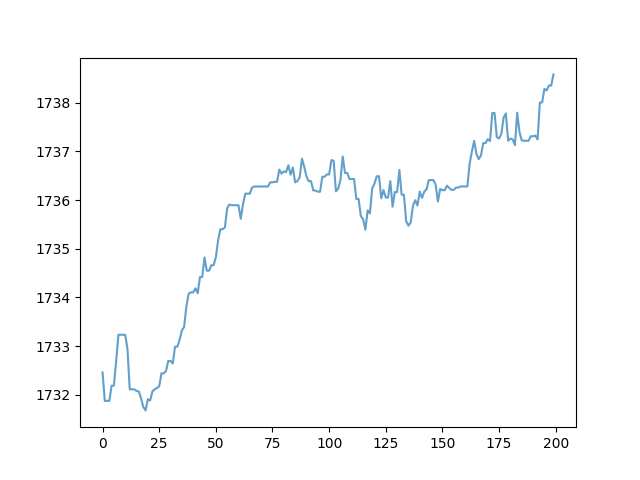

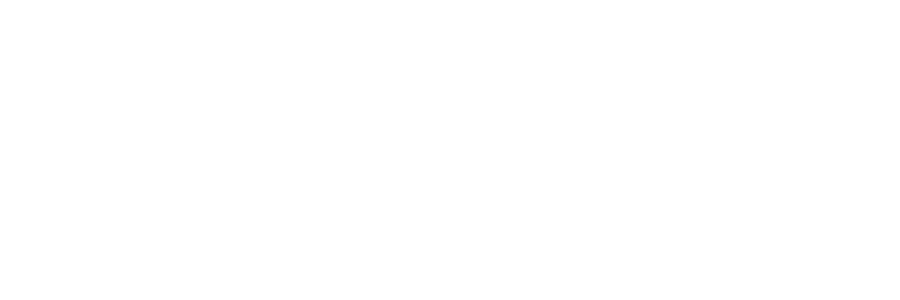

In [ ]:
# plot traces

for prm_idx in range(24):
    fig, ax = plt.subplots()
    plt.figure(figsize=(9, 3))
    for chain in range(4):
        ax.plot(trace.posterior['theta'].sel(chain=chain, theta_dim_0=prm_idx), alpha=0.7, label=f'Chain {chain}')
        ax.set_title(f'parameter: {PRM_ORDER_FULL[prm_idx]}')
        